In [7]:
from data_loader import OpenImagesDataset, collate_fn
from model_utils import plot_tensor, plot_image
from model_transformations import Transformations
from torch.utils.data import DataLoader
from params import DEVICE, CPU_DEVICE
from model import DogDetectorModel
import torch
from model_trainer import trainer
from model_evaluator import evaluator
from non_max_surpression import NonMaxSurpression

In [2]:
# Initializing the model
model = DogDetectorModel()

# Moving to training device
model = model.to(DEVICE)

In [3]:
BATCH_SIZE = 2

In [4]:
# Reading in the training data
trainingData = OpenImagesDataset(rootDirectory='open-images-v6',
                                 transform=Transformations, 
                                 dataType='train')    

# Defining the training data
trainDataLoader = DataLoader(dataset=trainingData, 
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False, collate_fn=collate_fn, pin_memory=True)

# Reading in the training data
validationData = OpenImagesDataset(rootDirectory='open-images-v6',
                                 transform=Transformations, 
                                 dataType='validation')    

# Defining the training data
validationDataLoader = DataLoader(dataset=validationData, 
                             batch_size=5,
                             num_workers=2,
                             shuffle=False, collate_fn=collate_fn, pin_memory=True)

In [5]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Defining the learning rate that makes a step every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
NUM_EPOCHS = 10

In [ ]:
BEST_MAP = 0

In [ ]:
for epoch in range(NUM_EPOCHS):
    # ***************** TRAINING ******************    

#     trainer(model, optimizer, trainDataLoader, epoch)
    
#     # Updating the learning rate scheduler
#     lr_scheduler.step()
    
    # ***************** EVALUATION ******************    

    coco_evaluator, MAP = evaluator(model, validationDataLoader)
    
    print('MAP:', MAP)
    
    if MAP > BEST_MAP:
        print('Saving New Model')
        PATH = "model.pt"
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': MAP,
        }, PATH)
        
        BEST_MAP = MAP
        
    

    
   


# Loading and View Predictions

In [8]:
nms = NonMaxSurpression()

In [10]:
checkpoint = torch.load('model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
images, targets = next(iter(validationDataLoader))

In [12]:
images = list(image.to(DEVICE) for image in images)

In [13]:
model.eval()
outputs = model(images, targets)

/home/aidan/Programs/miniconda3/envs/dogapp/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
outputs = [{k: v.to(CPU_DEVICE) for k, v in t.items()} for t in outputs]

In [15]:
images = [img.to(CPU_DEVICE) for img in images]

In [16]:
outputs = nms(outputs)

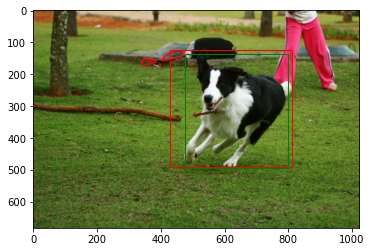

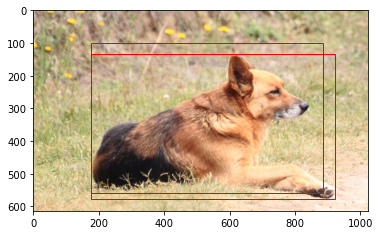

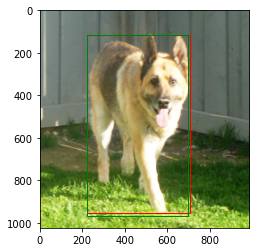

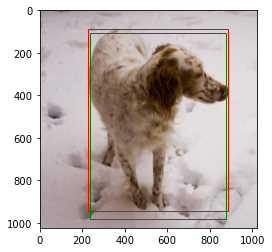

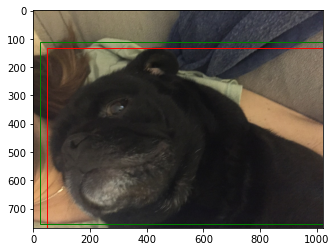

In [19]:
for i in range(0, len(images)):
    plot_tensor(images[i],targets[i]['boxes'], outputs[i]['boxes'])